In [ ]:
from google.colab import drive
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, DepthwiseConv2D,Dropout
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
glob('/content/gdrive/MyDrive/ROIJPG (1)/*G*/*')

['/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_1.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_15.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_16.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_13.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_7.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_12.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_2.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_9.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_14.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_3.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_5.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_17.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_10.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_18.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_8.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_19.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_6.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_4.jpeg',
 '/content/gdrive/MyDrive/ROIJPG (1)/G1/g1_11.jpeg',
 '

In [ ]:
len(glob('/content/gdrive/MyDrive/ROIJPG (1)/*G*/*'))

1130

In [ ]:
from glob import glob

# Paths to the dataset
Grade_1 = glob('/content/gdrive/MyDrive/ROIJPG (1)/G1*/*')
Grade_2 = glob('/content/gdrive/MyDrive/ROIJPG (1)/G2*/*')
Grade_3 = glob('/content/gdrive/MyDrive/ROIJPG (1)/G3*/*')

In [ ]:
print ("Grade_1: ",len(Grade_1))
print ("Grade_2: ",len(Grade_2))
print ("Grade_3: ",len(Grade_3))

Grade_1:  377
Grade_2:  376
Grade_3:  377


In [ ]:
def read_and_preprocess_images(file_paths, num_images_per_file=376, resize_dim=(224, 224)):
    images = []
    num_images_read = 0

    for file_path in file_paths:
        if os.path.isfile(file_path) and file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)

            if img is not None:
                img = cv2.resize(img, resize_dim)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                images.append(img)
                num_images_read += 1

                if num_images_read >= num_images_per_file:
                    break

    return np.array(images)





In [ ]:
# Load and preprocess the data
images_grade_1 = read_and_preprocess_images(Grade_1, num_images_per_file=376)
images_grade_2 = read_and_preprocess_images(Grade_2, num_images_per_file=376)
images_grade_3 = read_and_preprocess_images(Grade_3, num_images_per_file=376)

In [ ]:
print ("images_grade_1: ",len(images_grade_1))
print ("images_grade_2: ",len(images_grade_2))
print ("images_grade_3: ",len(images_grade_3))

images_grade_1:  376
images_grade_2:  376
images_grade_3:  376


In [ ]:
images = np.concatenate((images_grade_1, images_grade_2, images_grade_3), axis=0)
labels = np.array([0]*len(images_grade_1) + [1]*len(images_grade_2) + [2]*len(images_grade_3))

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

# Perform one-hot encoding on labels
labels = to_categorical(labels)

# Normalize pixel values
images = images.astype('float32') / 255.0

# Partition the data into training and testing splits using 80% of the data for training
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.20, random_state=42, stratify=labels)

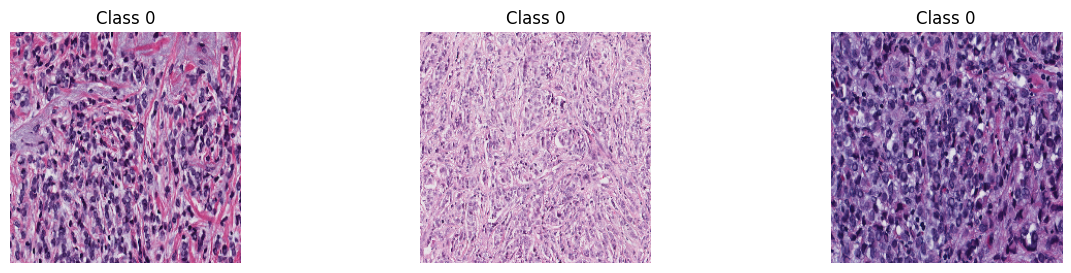

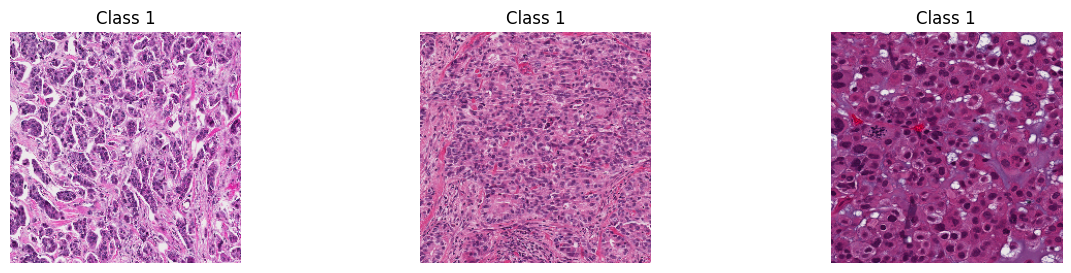

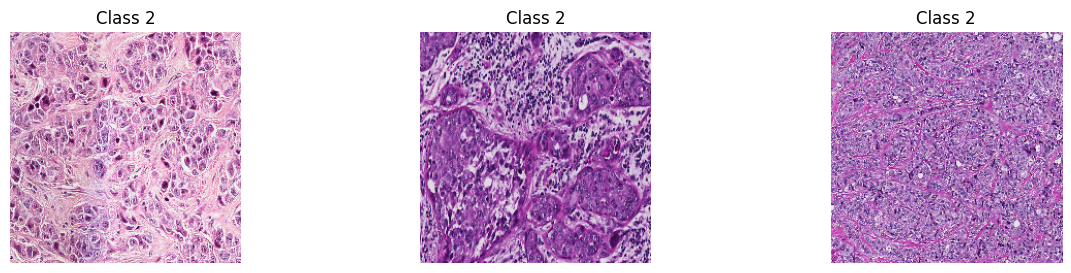

In [ ]:
import matplotlib.pyplot as plt

# Function to display sample images
def display_sample_images(images, labels, num_samples_per_class=3):
    classes = np.unique(np.argmax(labels, axis=1))

    for cls in classes:
        indices = np.where(np.argmax(labels, axis=1) == cls)[0]
        np.random.shuffle(indices)  # Shuffle the indices
        sample_indices = indices[:num_samples_per_class]

        plt.figure(figsize=(15, 3))
        for i, index in enumerate(sample_indices):
            plt.subplot(1, num_samples_per_class, i+1)
            plt.imshow(images[index])
            plt.title(f'Class {cls}')
            plt.axis('off')
        plt.show()

# Display sample images
display_sample_images(images, labels)



In [ ]:
pip install tensorflow-hub


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Load MobileNetV3 model from TensorFlow Hub
module_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'
base_model = hub.KerasLayer(module_handle)

# Wrap the base_model in a Sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),


    tf.keras.layers.Dense(3, activation='softmax')
])

# Build the model
model.build((None, 224, 224, 3))

# Display model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              2555993   
                                                                 
 batch_normalization_1 (Bat  (None, 1001)              4004      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 1001)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               513024    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset directory
dataset_dir = '/content/gdrive/MyDrive/ROIJPG (1)'

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create generators for training and validation data
target_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'  # This subset parameter is used to specify training split
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # This subset parameter is used to specify validation split
)


Found 905 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [ ]:
# Learning Rate Scheduling
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [ ]:
# Learning rate scheduling
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Get the class labels and their frequencies
labels, counts = np.unique(train_generator.classes, return_counts=True)

# Calculate class weights
total_samples = np.sum(counts)
class_weights = {label: total_samples / (len(labels) * count) for label, count in zip(labels, counts)}

# Compile the model with class weights
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=70,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping],

    class_weight=class_weights
)


Epoch 1/70
29/29 [==============================] - 92s 3s/step - loss: 1.6574 - accuracy: 0.4409 - val_loss: 2.0241 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 2/70
29/29 [==============================] - 85s 3s/step - loss: 1.4169 - accuracy: 0.5315 - val_loss: 1.1086 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 3/70
29/29 [==============================] - 84s 3s/step - loss: 1.2718 - accuracy: 0.5713 - val_loss: 0.9745 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 4/70
29/29 [==============================] - 83s 3s/step - loss: 1.1613 - accuracy: 0.6011 - val_loss: 0.9139 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 5/70
29/29 [==============================] - 77s 3s/step - loss: 1.1044 - accuracy: 0.5912 - val_loss: 0.9568 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 6/70
29/29 [==============================] - 72s 3s/step - loss: 0.9768 - accuracy: 0.6320 - val_loss: 1.0000 - val_accuracy: 0.5911 - lr: 0.0010
Epoch 7/70
29/29 [==============================] - 71s 2s/step - loss: 0.9733 - a

In [ ]:
# Unfreeze the top layers of the model
for layer in model.layers:

    layer.trainable =False

# Compile the model for fine-tuning
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model with fine-tuning
history_fine = model.fit(train_generator,
                          steps_per_epoch=train_generator.n // 32,
                          epochs=300,
                          initial_epoch=history.epoch[-1],
                          shuffle=True,
                           callbacks=[lr_scheduler, early_stopping],
                          validation_data=validation_generator,
                          validation_steps=validation_generator.n //32)

Epoch 38/300
28/28 [==============================] - 75s 3s/step - loss: 0.4759 - accuracy: 0.8121 - val_loss: 0.6282 - val_accuracy: 0.7455 - lr: 9.0484e-05
Epoch 39/300
28/28 [==============================] - 72s 3s/step - loss: 0.5101 - accuracy: 0.7927 - val_loss: 0.5873 - val_accuracy: 0.7946 - lr: 8.1873e-05
Epoch 40/300
28/28 [==============================] - 77s 3s/step - loss: 0.4745 - accuracy: 0.7938 - val_loss: 0.6179 - val_accuracy: 0.7723 - lr: 7.4082e-05
Epoch 41/300
28/28 [==============================] - 86s 3s/step - loss: 0.4831 - accuracy: 0.8121 - val_loss: 0.6221 - val_accuracy: 0.7321 - lr: 6.7032e-05
Epoch 42/300
28/28 [==============================] - 83s 3s/step - loss: 0.5355 - accuracy: 0.7789 - val_loss: 0.5997 - val_accuracy: 0.7366 - lr: 6.0653e-05
Epoch 43/300
28/28 [==============================] - 80s 3s/step - loss: 0.4840 - accuracy: 0.8076 - val_loss: 0.6394 - val_accuracy: 0.7321 - lr: 5.4881e-05
Epoch 44/300
28/28 [==========================